# Data exploration

Visual exploration of the input data.

In [146]:
import uproot
import numpy as np
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from reco.plotting import get_event_window
from reco.distance import get_z_map

ds_name = "CloseByGamma200PUFull"
file_name = "new_ntuples_15410634_194.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

file_path = f"{raw_dir}/{file_name}"
tracksters = uproot.open({file_path: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_path: "ticlNtuplizer/associations"})
clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})


z_map = get_z_map(data_root)

ev_per_file = len(tracksters["raw_em_energy"].array())
print("Events per file:", ev_per_file)

Events per file: 10


In [147]:
hist = uproot.open({file_path: "ticlNtuplizer"})
hist.keys()
# trackstersMerged = uproot.open({file_path: "ticlNtuplizer/trackstersMerged"})

['tracksters;1',
 'clusters;1',
 'graph;1',
 'candidates;1',
 'trackstersMerged;1',
 'associations;1',
 'simtrackstersSC;1',
 'simtrackstersCP;1',
 'tracks;1']

In [148]:
print("NTracksters:", tracksters["NTracksters"].array())
print("NSimTracksters:", simtracksters["stsSC_NTracksters"].array())

NTracksters: [3138, 3060, 3533, 3767, 3083, 3180, 2803, 2775, 3250, 3264]
NSimTracksters: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [149]:
clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})
clusters_x = clusters["position_x"].array()
clusters_y = clusters["position_y"].array()
clusters_z = clusters["position_z"].array()
clusters_e = clusters["energy"].array()

In [150]:
eid = 0

vi = tracksters["vertices_indexes"].array()[eid]
# vi = simtracksters["stsSC_vertices_indexes"].array()[0:eid]

# only take one endcap
vz = ak.Array([clusters_z[eid][indices] for indices in vi])
# tdx = vz > 0

vx = ak.Array([clusters_x[eid][indices] for indices in vi])
vy = ak.Array([clusters_y[eid][indices] for indices in vi])
ve = ak.Array([clusters_e[eid][indices] for indices in vi])

vzm = vz
# vzm = [apply_map(trk, z_map) for trk in vz]

xlim, ylim, zlim = get_event_window(vx, vy, vzm, ve)

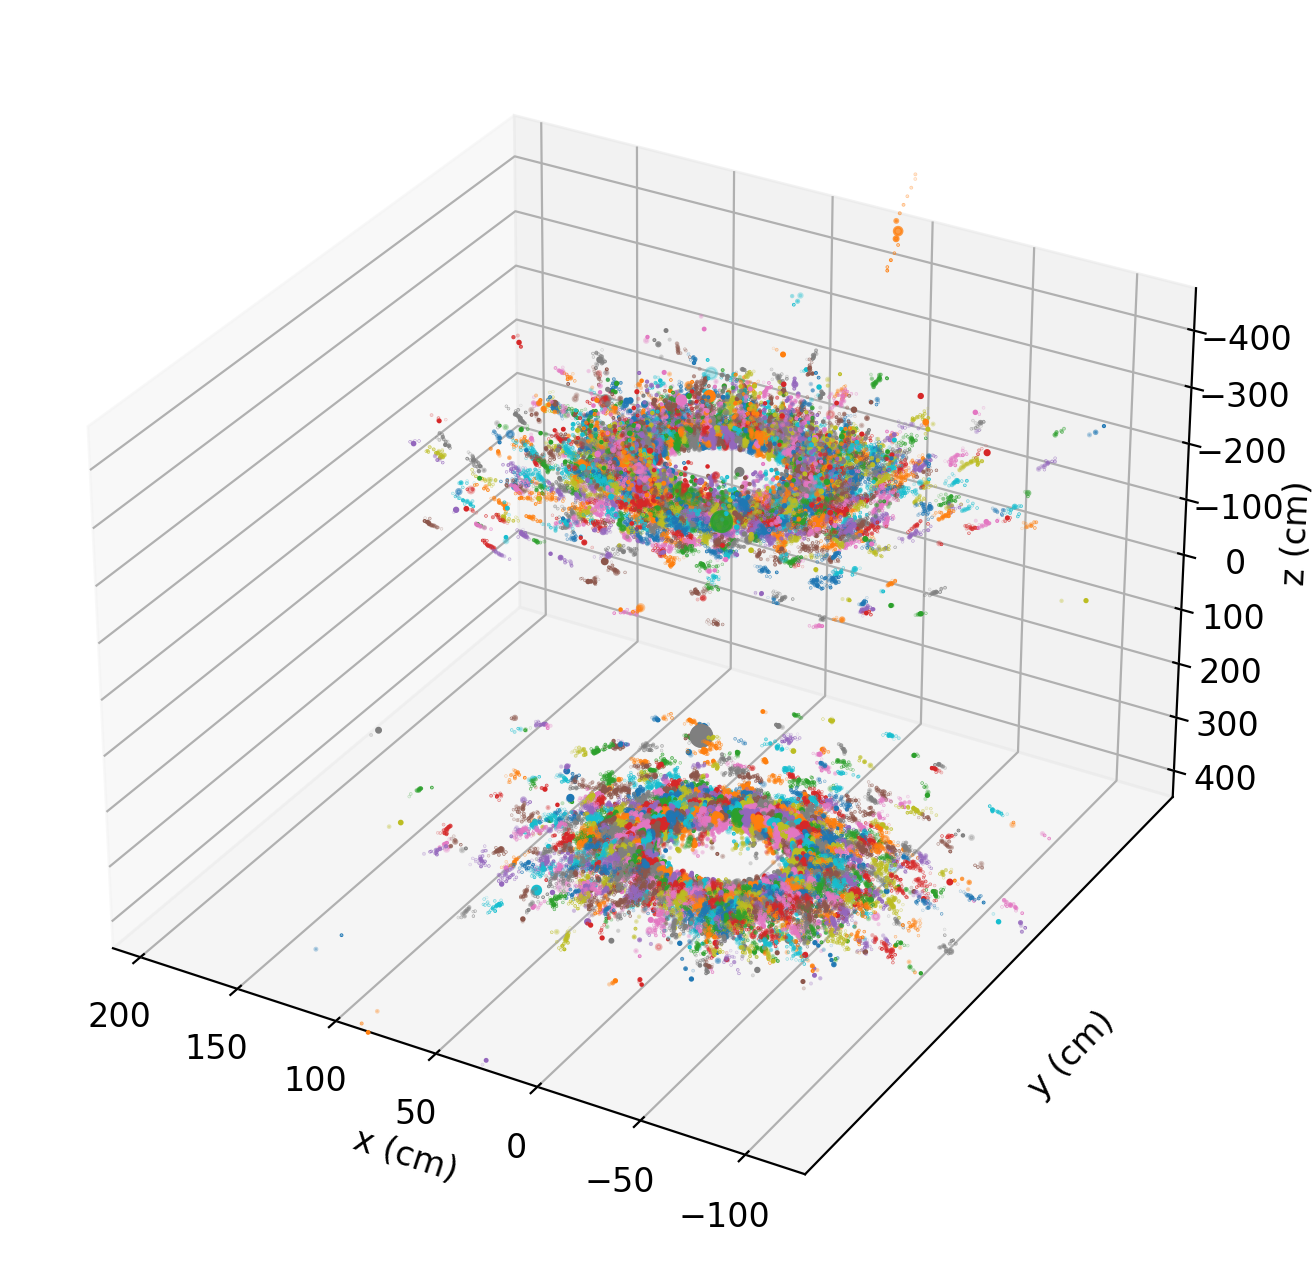

In [151]:
fig = plt.figure(figsize=(8, 8))
# sns.set(style="whitegrid")

ax1 = fig.add_subplot(111, projection='3d')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_zlim(zlim)
ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")
# ax1.set_zlabel("detector layer")
ax1.set_zlabel("z (cm)")
# plt.axis('off')

for x, y, z, e in zip(vx, vy, vzm, ve):
    ax1.scatter(x, y, z, s=e)

# ax1.set_title(f"Front view: reconstruction layer-clusters ({len(vx)})")
# ax1.view_init(0, 180, "x")

ax1.get_yaxis().set_ticks([])
ax1.get_yaxis().set_visible(False)

# Interpretation

I got a single particle and a lot of mess in the reco data.

I only care about the reconstruction quality of this single particle.

How do I know which particle is interesting to me?

I only care about the neighbourhood of this particular trackster?

I could do "min-max" on x,y,z coordinates of the sim-trackster and construct a prism / cone / frustum of all reco-tracksters with a barycentre inside of it.

Let's have a look at an usual profile of a pion.

In [152]:
x_dev = []
y_dev = []
z_dev = []
cle_e = []

# collect averages from 100 tracksters

for fid in range(10):
    fname = f"new_ntuples_15410634_19{fid}.root"
    file_path = f"{raw_dir}/{fname}"
    
    clusters = uproot.open({file_path: "ticlNtuplizer/clusters"})
    simtracksters = uproot.open({file_path: "ticlNtuplizer/simtrackstersSC"})

    for eid in range(10):
        clusters_x = clusters["position_x"].array()[eid]
        clusters_y = clusters["position_y"].array()[eid]
        clusters_z = clusters["position_z"].array()[eid]
        clusters_e = clusters["energy"].array()[eid]
        svi = simtracksters["stsSC_vertices_indexes"].array()[eid]
        
        svx = ak.Array([clusters_x[indices] for indices in svi])
        svy = ak.Array([clusters_y[indices] for indices in svi])
        svz = ak.Array([clusters_z[indices] for indices in svi])
        sve = ak.Array([clusters_e[indices] for indices in svi])
        
        tid = 0 # single trackster
        xm = np.mean(svx[tid])
        ym = np.mean(svy[tid])
        zm = np.mean(svz[tid])
        x_dev += [x-xm for x in svx[tid]]
        y_dev += [x-ym for x in svy[tid]]
        z_dev += [x-zm for x in svz[tid]]
        cle_e += [x for x in sve[tid]]

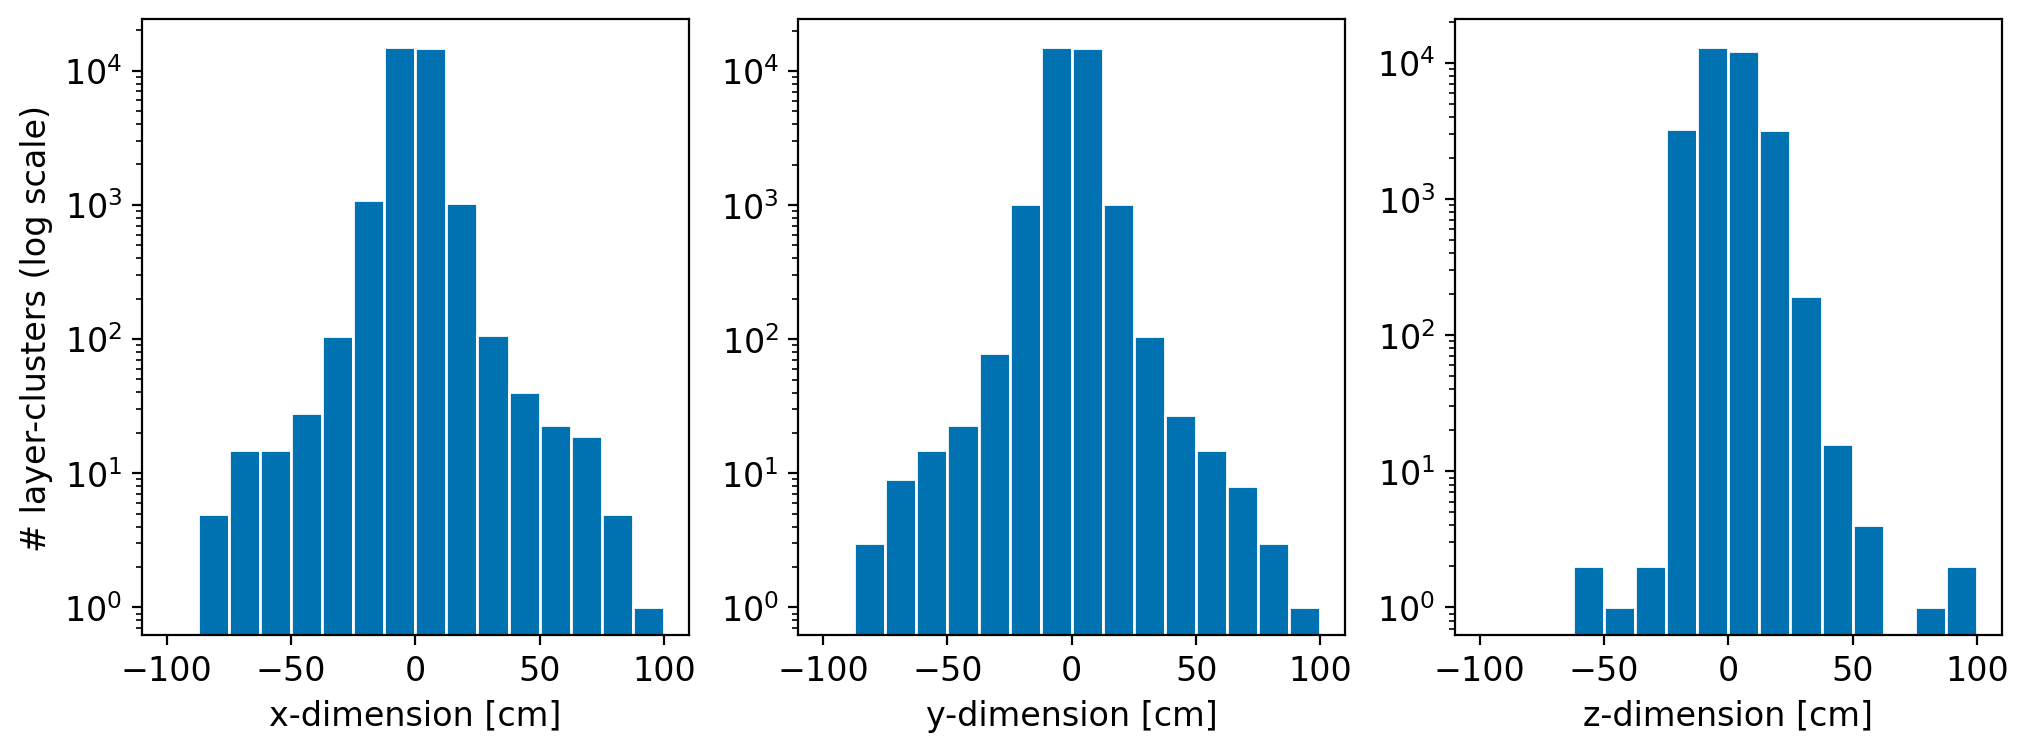

In [155]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.set_ylabel("# layer-clusters (log scale)")

ax1.set_xlabel("x-dimension [cm]")
ax1.set_yscale("log")
ax1.hist(x_dev, edgecolor="white", color="#0072B2", range=(-100, 100), bins=16)

ax2.set_xlabel("y-dimension [cm]")
ax2.set_yscale("log")
ax2.hist(y_dev, edgecolor="white", color="#0072B2", range=(-100, 100), bins=16)

ax3.set_yscale("log")
ax3.set_xlabel("z-dimension [cm]")
ax3.hist(z_dev, edgecolor="white", color="#0072B2", range=(-100, 100), bins=16)

# fig.savefig('export/photon-distribution.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Compute average X and Y per layer

In [132]:
eid = 0
clusters_x = clusters["position_x"].array()[eid]
clusters_y = clusters["position_y"].array()[eid]
clusters_z = clusters["position_z"].array()[eid]
clusters_e = clusters["energy"].array()[eid]

svi = simtracksters["stsSC_vertices_indexes"].array()[eid]
svz = ak.Array([clusters_z[indices] for indices in svi])
svx = ak.Array([clusters_x[indices] for indices in svi])
svy = ak.Array([clusters_y[indices] for indices in svi])
sve = ak.Array([clusters_e[indices] for indices in svi])

In [133]:
all_z = list(sorted(set(svz[tid])))

x_coords = {z: [] for z in all_z}
y_coords = {z: [] for z in all_z}
layer_e = {z: [] for z in all_z}

In [134]:
for x, y, z, e in zip(svx[tid], svy[tid], svz[tid], sve[tid]):
    x_coords[z].append(x)   
    y_coords[z].append(y)
    layer_e[z].append(e)

In [135]:
x_avg = []
y_avg = []
e_sum = []

for z in all_z:
    x_avg.append(np.mean(x_coords[z]))  # should weight by energy and multiplicity here
    y_avg.append(np.mean(y_coords[z]))  # should weight by energy and multiplicity here
    e_sum.append(np.sum(layer_e[z]))

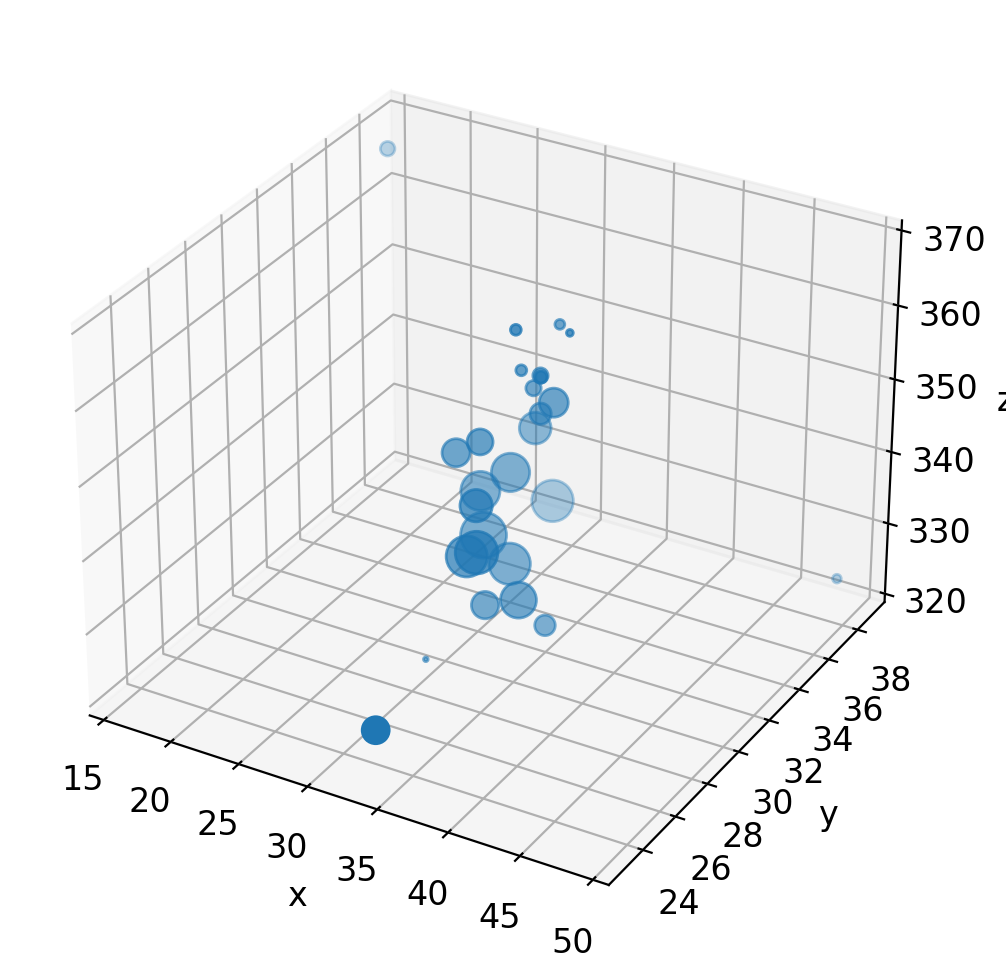

In [137]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_avg, y_avg, all_z, s=np.array(e_sum)*10)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# ax.view_init(45, 45, "x")
plt.show()

Plot deviation from the layer mean

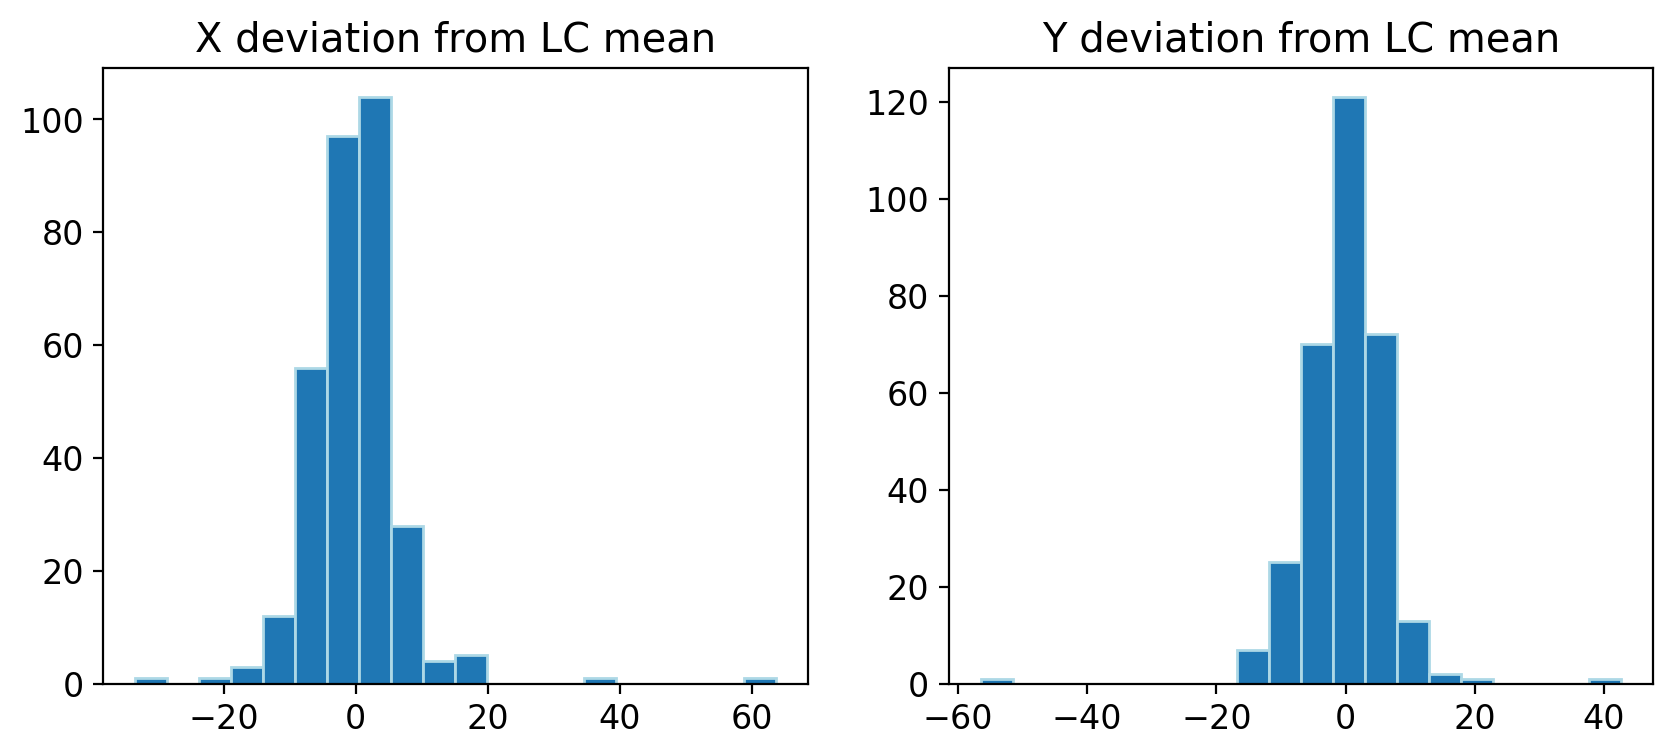

In [145]:
x_dev = []
y_dev = []

for i, z in enumerate(all_z):
    xm = x_avg[i]
    ym = y_avg[i]
    x_dev += [xm - x for x in x_coords[z]]
    y_dev += [ym - y for y in y_coords[z]]

fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_title("X deviation from LC mean")
ax1.hist(x_dev, bins=20, edgecolor="lightblue")

ax2.set_title("Y deviation from LC mean")
ax2.hist(y_dev, bins=20, edgecolor="lightblue")

plt.show()


# Plot everything within a cylinder (PU)

This belongs to Approach.

In [128]:
vi = tracksters["vertices_indexes"].array()[eid]
vx = ak.Array([clusters_x[eid][indices] for indices in vi])
vy = ak.Array([clusters_y[eid][indices] for indices in vi])
vz = ak.Array([clusters_z[eid][indices] for indices in vi])
ve = ak.Array([clusters_e[eid][indices] for indices in vi])

bx = tracksters["barycenter_x"].array()[eid]
by = tracksters["barycenter_y"].array()[eid]
bz = tracksters["barycenter_z"].array()[eid]

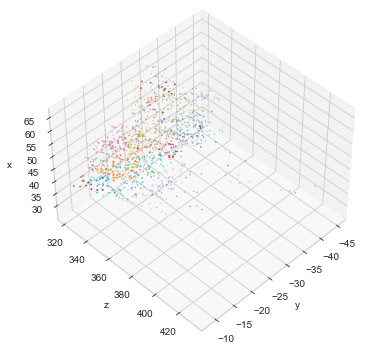

In [129]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

for tx, ty, tz, te, tbx, tby, tbz in zip(vx, vy, vz, ve, bx, by, bz):
    plot = False
    # find closest layer to the barycenter
    # bl = np.argmin(np.array(all_z) < bz)

    for x, y, zm, e in zip(tx, ty, tz, te):
        if zm not in x_coords:
            continue
        xm = np.mean(x_coords[zm])
        ym = np.mean(y_coords[zm])
        dst = np.sqrt((xm - x)**2 + (ym - y)**2)
        if dst < 10:
            plot = True
            break
    if plot:
        ax.scatter(tx, ty, tz, s=e*2)

# ax.scatter(x_avg, y_avg, all_z, s=np.array(e_sum))
ax.view_init(45, 45, "x")
plt.show()

## Selection

select a trackster having at least 50% of the simtrackster energy an is above 10GeV

In [130]:
scores_above_50 = []
scores_below_50 = []
shared_dists = []
shared_dist_reco = []

for eid in range(ev_per_file):
    raw_energy = tracksters["raw_energy"].array()[eid]
    sim_raw_energy = simtracksters["stsSC_raw_energy"].array()[eid]
    print(f"total tracksters: {len(raw_energy)}, above 10 GeV: {sum(raw_energy > 10)}, non-zero shared energy:")

    reco2sim_index = np.array(associations["tsCLUE3D_recoToSim_SC"].array()[eid])
    reco2sim_shared = np.array(associations["tsCLUE3D_recoToSim_SC_sharedE"].array()[eid])
    reco2sim_score = np.array(associations["tsCLUE3D_recoToSim_SC_score"].array()[eid])

    # for each reco trackster
    for recoT_idx, (sim_indexes, shared_energies, scores) in enumerate(zip(reco2sim_index, reco2sim_shared, reco2sim_score)):
        # get the shared energy with all simm tracksters
        for simT_idx, shared_energy, score in zip(sim_indexes, shared_energies, scores):
            rt_e = raw_energy[recoT_idx]
            if shared_energy > 0 and score < 0.2:
                st_e = sim_raw_energy[simT_idx]
                fr = shared_energy / st_e
                if fr > 0.5:
                    scores_above_50.append(score)
                else:
                    shared_dists.append(fr)
                    shared_dist_reco.append(shared_energy / rt_e)
                    scores_below_50.append(score)
                print(f"\tsimE: {st_e:.3f}\trecoE: {rt_e:.3f}\tshared: {shared_energy:.3f}\tscore: {score:.4f}")

total tracksters: 3001, above 10 GeV: 283, non-zero shared energy:
	simE: 379.146	recoE: 360.208	shared: 336.510	score: 0.0014
	simE: 379.146	recoE: 2.255	shared: 1.508	score: 0.0320
	simE: 379.146	recoE: 0.874	shared: 0.792	score: 0.0045
total tracksters: 2927, above 10 GeV: 265, non-zero shared energy:
	simE: 522.173	recoE: 484.384	shared: 471.409	score: 0.0003
	simE: 522.173	recoE: 4.391	shared: 3.402	score: 0.0781
	simE: 522.173	recoE: 5.418	shared: 3.429	score: 0.1019
	simE: 522.173	recoE: 6.120	shared: 4.940	score: 0.1390
	simE: 522.173	recoE: 2.873	shared: 1.764	score: 0.1236
total tracksters: 3389, above 10 GeV: 337, non-zero shared energy:
	simE: 218.949	recoE: 208.201	shared: 191.204	score: 0.0024
	simE: 218.949	recoE: 2.717	shared: 2.260	score: 0.0154
total tracksters: 3083, above 10 GeV: 282, non-zero shared energy:
	simE: 82.392	recoE: 94.557	shared: 57.532	score: 0.0420
total tracksters: 2877, above 10 GeV: 289, non-zero shared energy:
	simE: 150.817	recoE: 158.884	shared

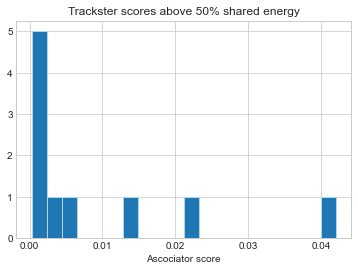

In [131]:
plt.title("Trackster scores above 50% shared energy")
plt.hist(scores_above_50, bins=20, edgecolor="lightblue")
plt.xlabel("Ascociator score")
plt.show()

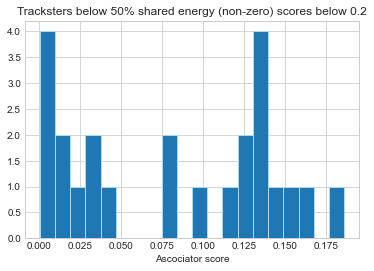

In [132]:
plt.title("Tracksters below 50% shared energy (non-zero) scores below 0.2")
plt.hist(scores_below_50, bins=20, edgecolor="lightblue")
plt.xlabel("Ascociator score")
plt.show()

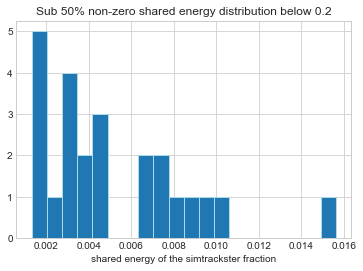

In [133]:
plt.title("Sub 50% non-zero shared energy distribution below 0.2")
plt.hist(shared_dists, bins=20, edgecolor="lightblue")
plt.xlabel("shared energy of the simtrackster fraction")
plt.show()

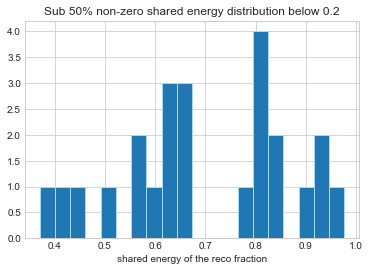

In [134]:
plt.title("Sub 50% non-zero shared energy distribution below 0.2")
plt.hist(shared_dist_reco, bins=20, edgecolor="lightblue")
plt.xlabel("shared energy of the reco fraction")
plt.show()